In [11]:
import pandas as pd
import plotnine as p9


In [12]:
def json_array_to_values(json_array):
    json_array = json_array.replace("\\xa0", " ")
    json_array = eval(json_array)

    values = []
    for genre in json_array:
        values.append(genre["name"])

    return values


df_md = pd.read_csv("the-movies-dataset/movies_metadata.csv")
drop_columns = {
    "adult",
    "belongs_to_collection",
    "homepage",
    "imdb_id",
    "original_title",
    "overview",
    "poster_path",
    "status",
    "tagline",
    "video",
    "spoken_languages",
}

dropping = {
    "TV Movie",
    "Foreign",
}

movie_clusters = {
    "Adventure": ["Adventure", "Fantasy"], # OK
    "Horror": ["Horror", "Science Fiction"], # OK
    "Documentary": ["Documentary", "History", "War"],  # OK
    "Action": ["Action", "Thriller", "Mystery", "Crime", "Western"], # OK
    "Animation": ["Animation", "Music", "Family"], # OK
    "Comedy": ["Comedy", "Romance"],  # OK
    "Drama": ["Drama"],  # OK
}

# Let's assign the main genre to each movie
def assign_main_genre(genres, clusters=movie_clusters):
    genres = [genre for genre in genres if genre not in dropping and genre != ""]
    if len(genres) == 0:
        return None

    main_movie_genre = genres[0]

    for cluster, cluster_genres in clusters.items():
        if main_movie_genre in cluster_genres:
            return cluster

    return None

df_md.drop(drop_columns, axis=1, inplace=True)

# Convert the release_date column to year, month and day
df_md = df_md[df_md["release_date"].str.len() == 10]
df_md["release_date"] = pd.to_datetime(df_md["release_date"])
df_md["release_year"] = df_md["release_date"].dt.year
df_md["release_month"] = df_md["release_date"].dt.month
df_md["release_day"] = df_md["release_date"].dt.day
df_md["release_quarter"] = df_md["release_date"].dt.quarter


df_md.dropna(subset=["release_year"], inplace=True)
df_md.dropna(subset=["release_month"], inplace=True)
df_md.dropna(subset=["release_day"], inplace=True)
df_md.dropna(subset=["release_quarter"], inplace=True)

df_md["season"] = df_md["release_month"].apply(
    lambda x: "Winter"
    if x in [12, 1, 2]
    else ("Spring" if x in [3, 4, 5] else ("Summer" if x in [6, 7, 8] else "Fall"))
)

df_md.drop("release_date", axis=1, inplace=True)

numeric_columns = [
    "id",
    "budget",
    "revenue",
    "runtime",
    "popularity",
    "vote_average",
    "vote_count",
    "release_year",
    "release_month",
    "release_day",
]

for column in numeric_columns:
    df_md[column] = pd.to_numeric(df_md[column], errors="coerce")

df_md.dropna(subset=numeric_columns, inplace=True)

# Convert the json columns to arrays
df_md["genres"] = df_md["genres"].apply(lambda x: json_array_to_values(x))
df_md["production_countries"] = df_md["production_countries"].apply(
    lambda x: json_array_to_values(x)
)
df_md["production_companies"] = df_md["production_companies"].apply(
    lambda x: json_array_to_values(x)
)

df_md = df_md[df_md["budget"] > 0]
df_md = df_md[df_md["revenue"] > 0]
df_md = df_md[df_md["production_companies"].apply(lambda x: len(x)) > 0]

# Create a new column with the main genre and the genre count
df_md["main_genre"] = df_md["genres"].apply(lambda x: assign_main_genre(x, movie_clusters))
df_md.dropna(subset=["main_genre"], inplace=True)
df_md["genre_count"] = df_md["genres"].apply(lambda x: len(x))


/var/folders/s0/tqtx5tfn21b8rys89pkqht4m0000gn/T/ipykernel_48867/3811018376.py:12: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


In [13]:
df_md.shape


(5199, 19)

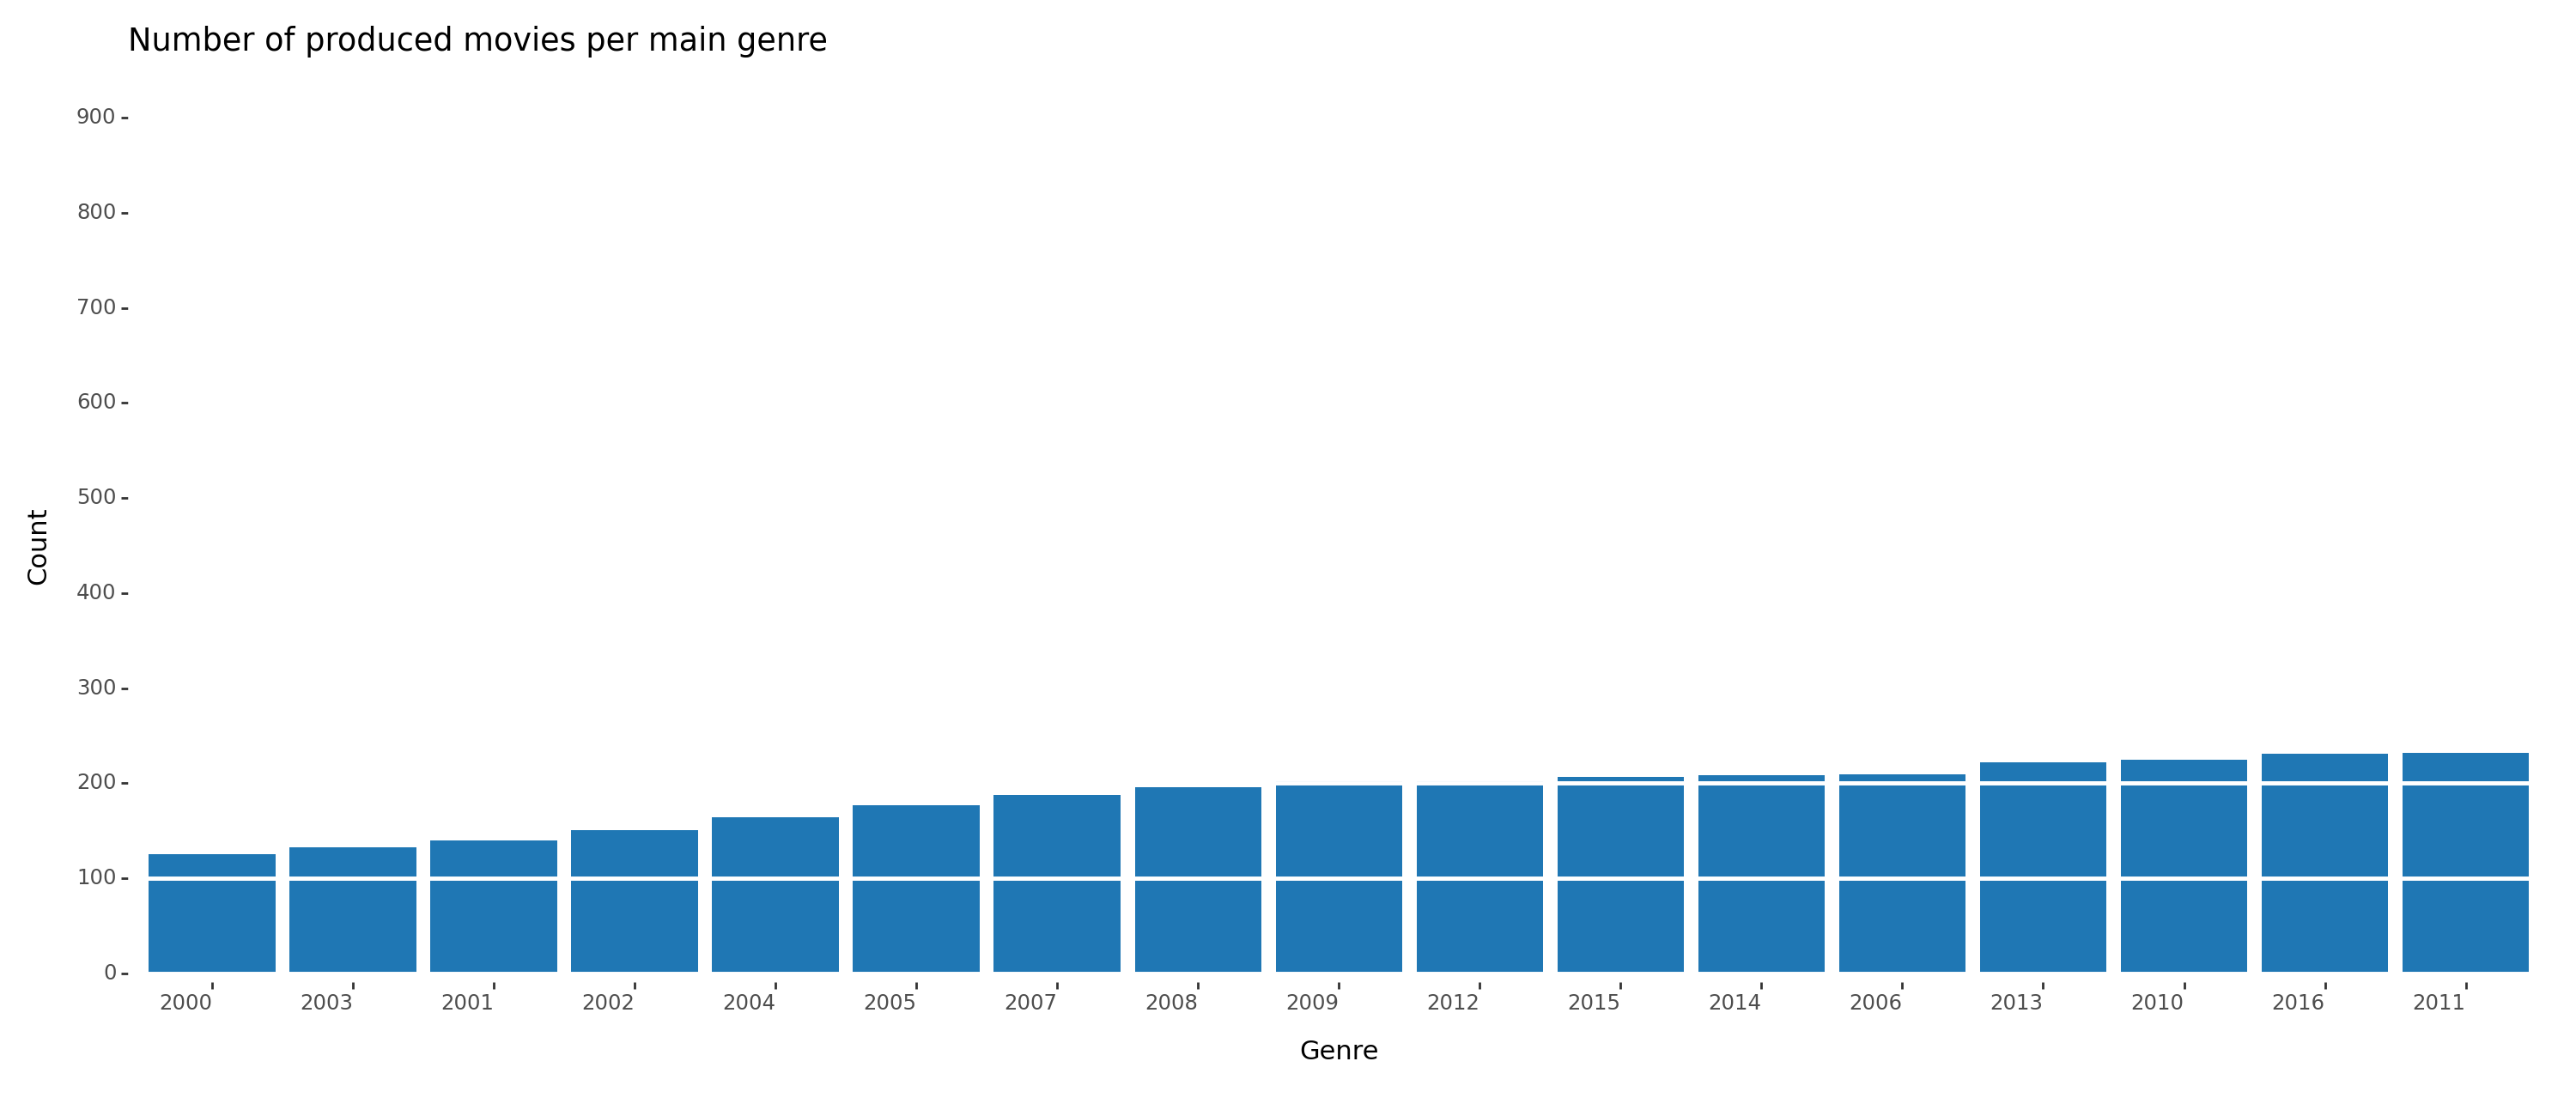

In [14]:
# Visualize the count by release year from 2000 to 2016
df_main_count = df_md.groupby("release_year").size().reset_index(name="count")
df_main_count = df_main_count.sort_values(by="count", ascending=False)
df_main_count = df_main_count[df_main_count["release_year"] >= 2000]
df_main_count = df_main_count[df_main_count["release_year"] <= 2016]


p = (
    p9.ggplot(
        df_main_count, p9.aes("reorder(release_year, count)", "count", fill="release_year")
    )
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    # + p9.coord_flip()
    + p9.theme(legend_position="none")
    + p9.scale_y_continuous(breaks=range(0, 1000, 100), expand=(0.01, 0.01))
    + p9.labs(x="Genre", y="Count", title="Number of produced movies per main genre")
    + p9.theme(
        axis_text_x=p9.element_text(rotation=0, hjust=1),
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#ffffff", size=0.5),
    )
    # overlay the bars with the grid lines
    + p9.geom_hline(yintercept=range(0, 1000, 100), color="#ffffff", size=1)
    # reduce the space between the bars and the grid lines
    + p9.guides(color=p9.guide_legend(ncol=2))
)
p.draw()


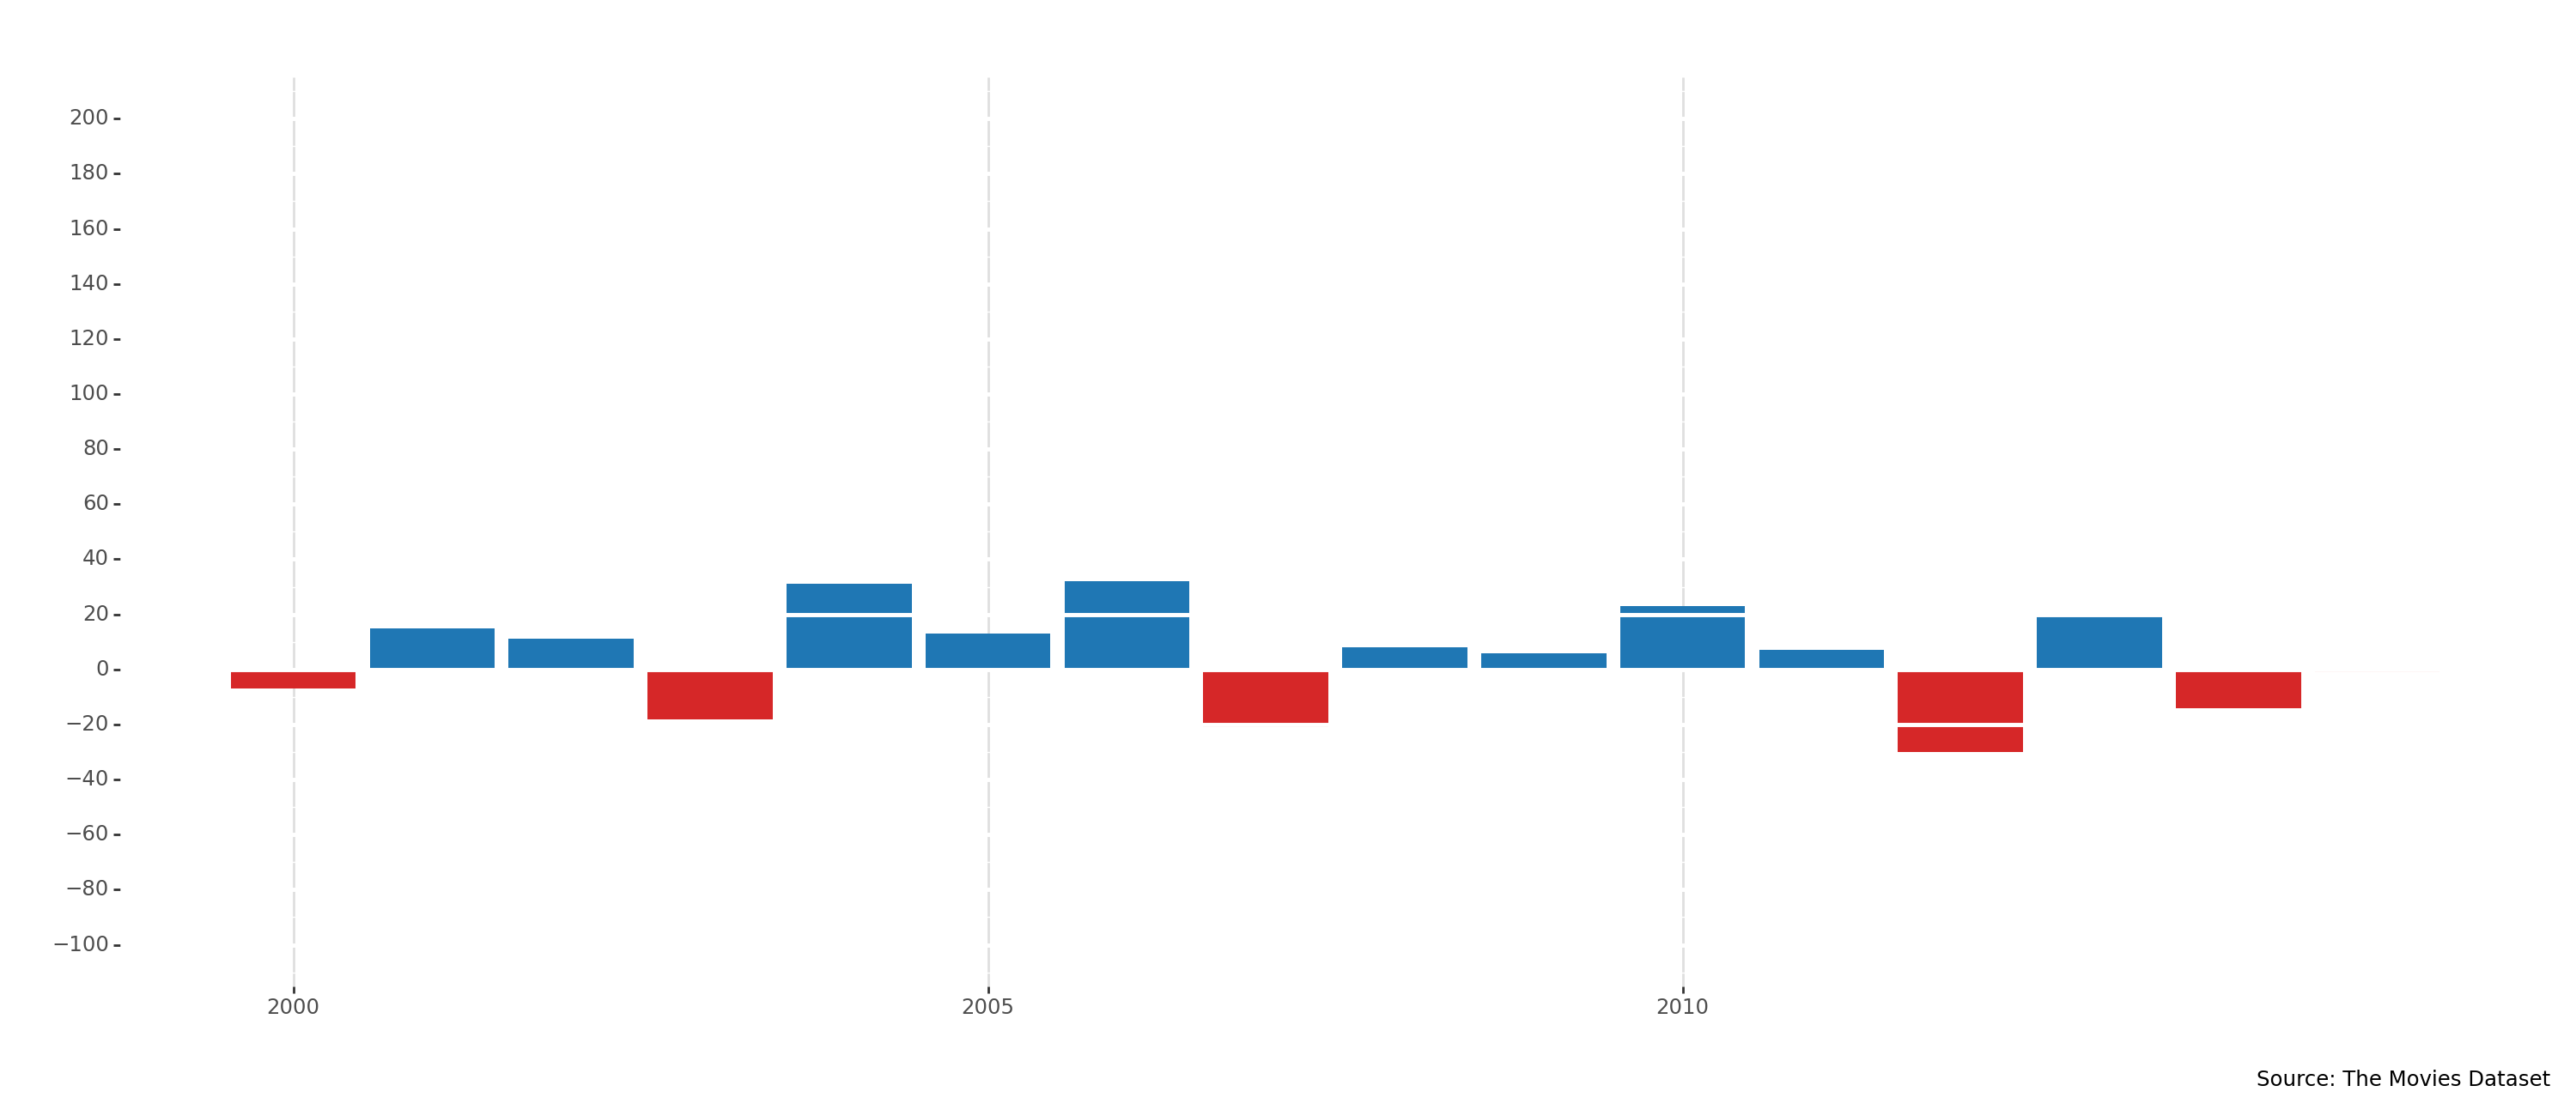

In [15]:
# Let's now see how the number of movies produced per year has evolved.
df_year_count = df_md.groupby("release_year").size().reset_index(name="count")
df_year_count = df_year_count.sort_values(by="release_year", ascending=True)
df_year_count["count"] = df_year_count["count"].astype(int)

df_year_count["count"] = df_year_count["count"].diff()
df_year_count = df_year_count.dropna(subset=["count"])
df_year_count["count"] = df_year_count["count"].astype(int)

# take only the years between 2000 and 2015
df_year_count = df_year_count[df_year_count["release_year"] >= 2000]
df_year_count = df_year_count[df_year_count["release_year"] <= 2015]

p = (
    p9.ggplot(df_year_count, p9.aes("release_year", "count"))
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.geom_bar(
        data=df_year_count[df_year_count["count"] < 0], stat="identity", fill="#d62728"
    )
    + p9.labs(
        x="",
        y="",
    )
    + p9.scale_x_continuous(breaks=range(1970, 2015, 5))
    + p9.scale_y_continuous(breaks=range(-100, 210, 20), expand=(0.05, 0.05))
    + p9.geom_hline(yintercept=range(-100, 210, 20), color="#ffffff", size=1)
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        plot_caption=p9.element_text(text="Source: The Movies Dataset"),
    )
)
p.draw()


In [16]:
# Classify the movies into 3 categories by runtime: short, medium and long
def classify_runtime(runtime):
    if runtime < 60:
        return "Short"
    elif runtime < 110:
        return "Medium"
    else:
        return "Long"

df_md["runtime_category"] = df_md["runtime"].apply(classify_runtime)


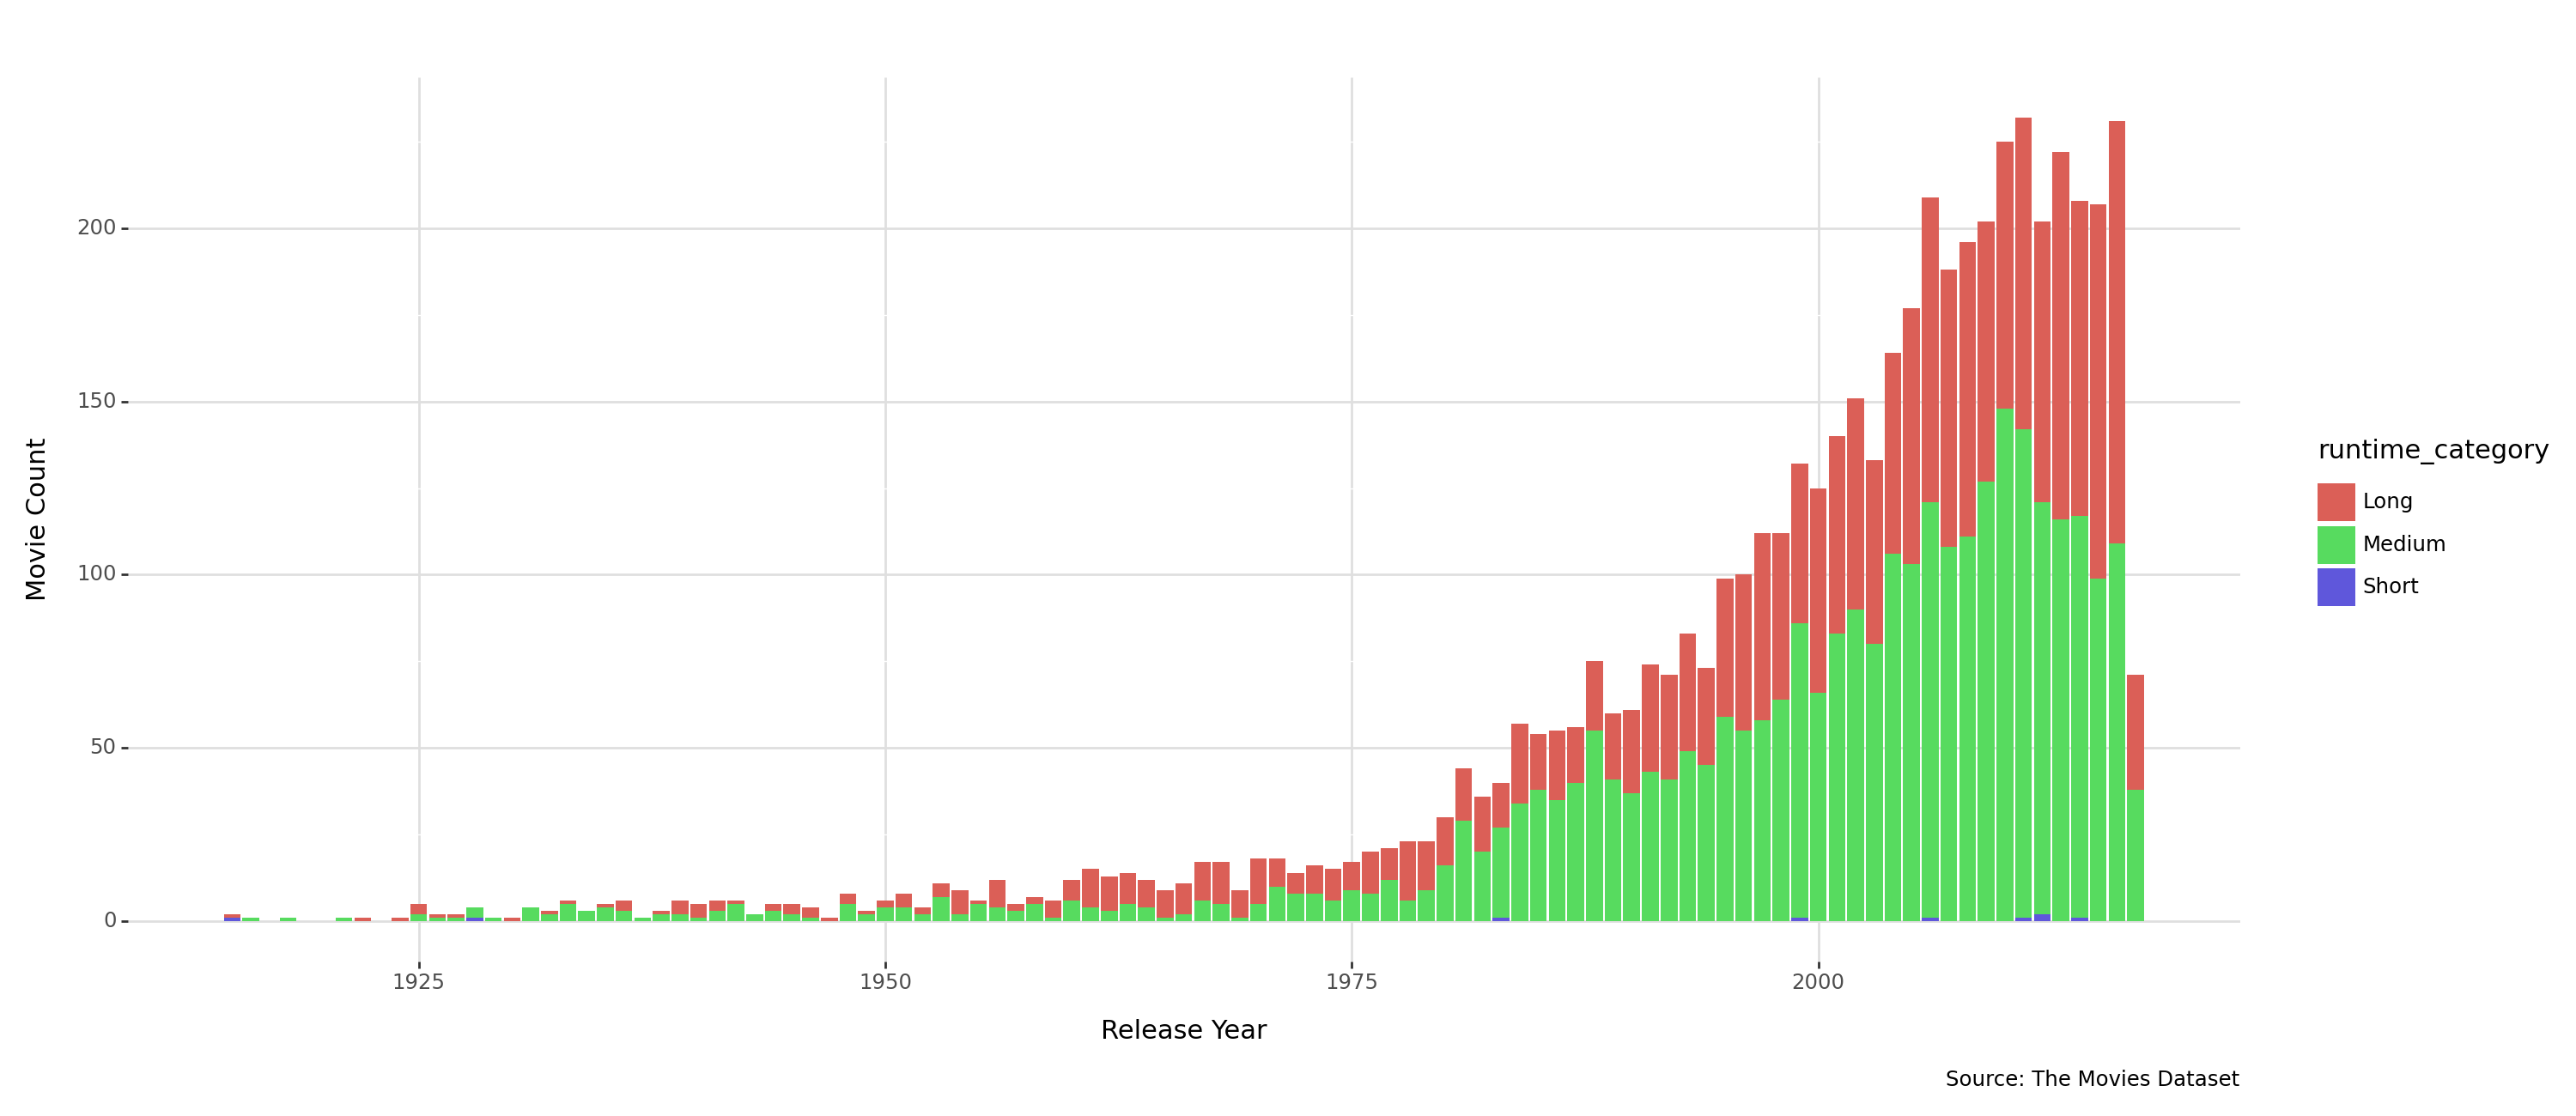

In [17]:
# Plot the runtime categories by year
df_runtime = df_md.groupby(["release_year", "runtime_category"]).size().reset_index(name="count")
df_runtime = df_runtime.sort_values(by="release_year", ascending=True)
df_runtime["count"] = df_runtime["count"].astype(int)

p = (
    p9.ggplot(df_runtime, p9.aes("release_year", "count", fill="runtime_category"))
    + p9.geom_bar(stat="identity")
    + p9.labs(
        x="Release Year",
        y="Movie Count",
    )
    # + p9.scale_x_continuous(breaks=range(1970, 2015, 5))
    # + p9.scale_y_continuous(breaks=range(0, 1000, 100), expand=(0.05, 0.05))
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        plot_caption=p9.element_text(text="Source: The Movies Dataset"),
    )
)
p.draw()


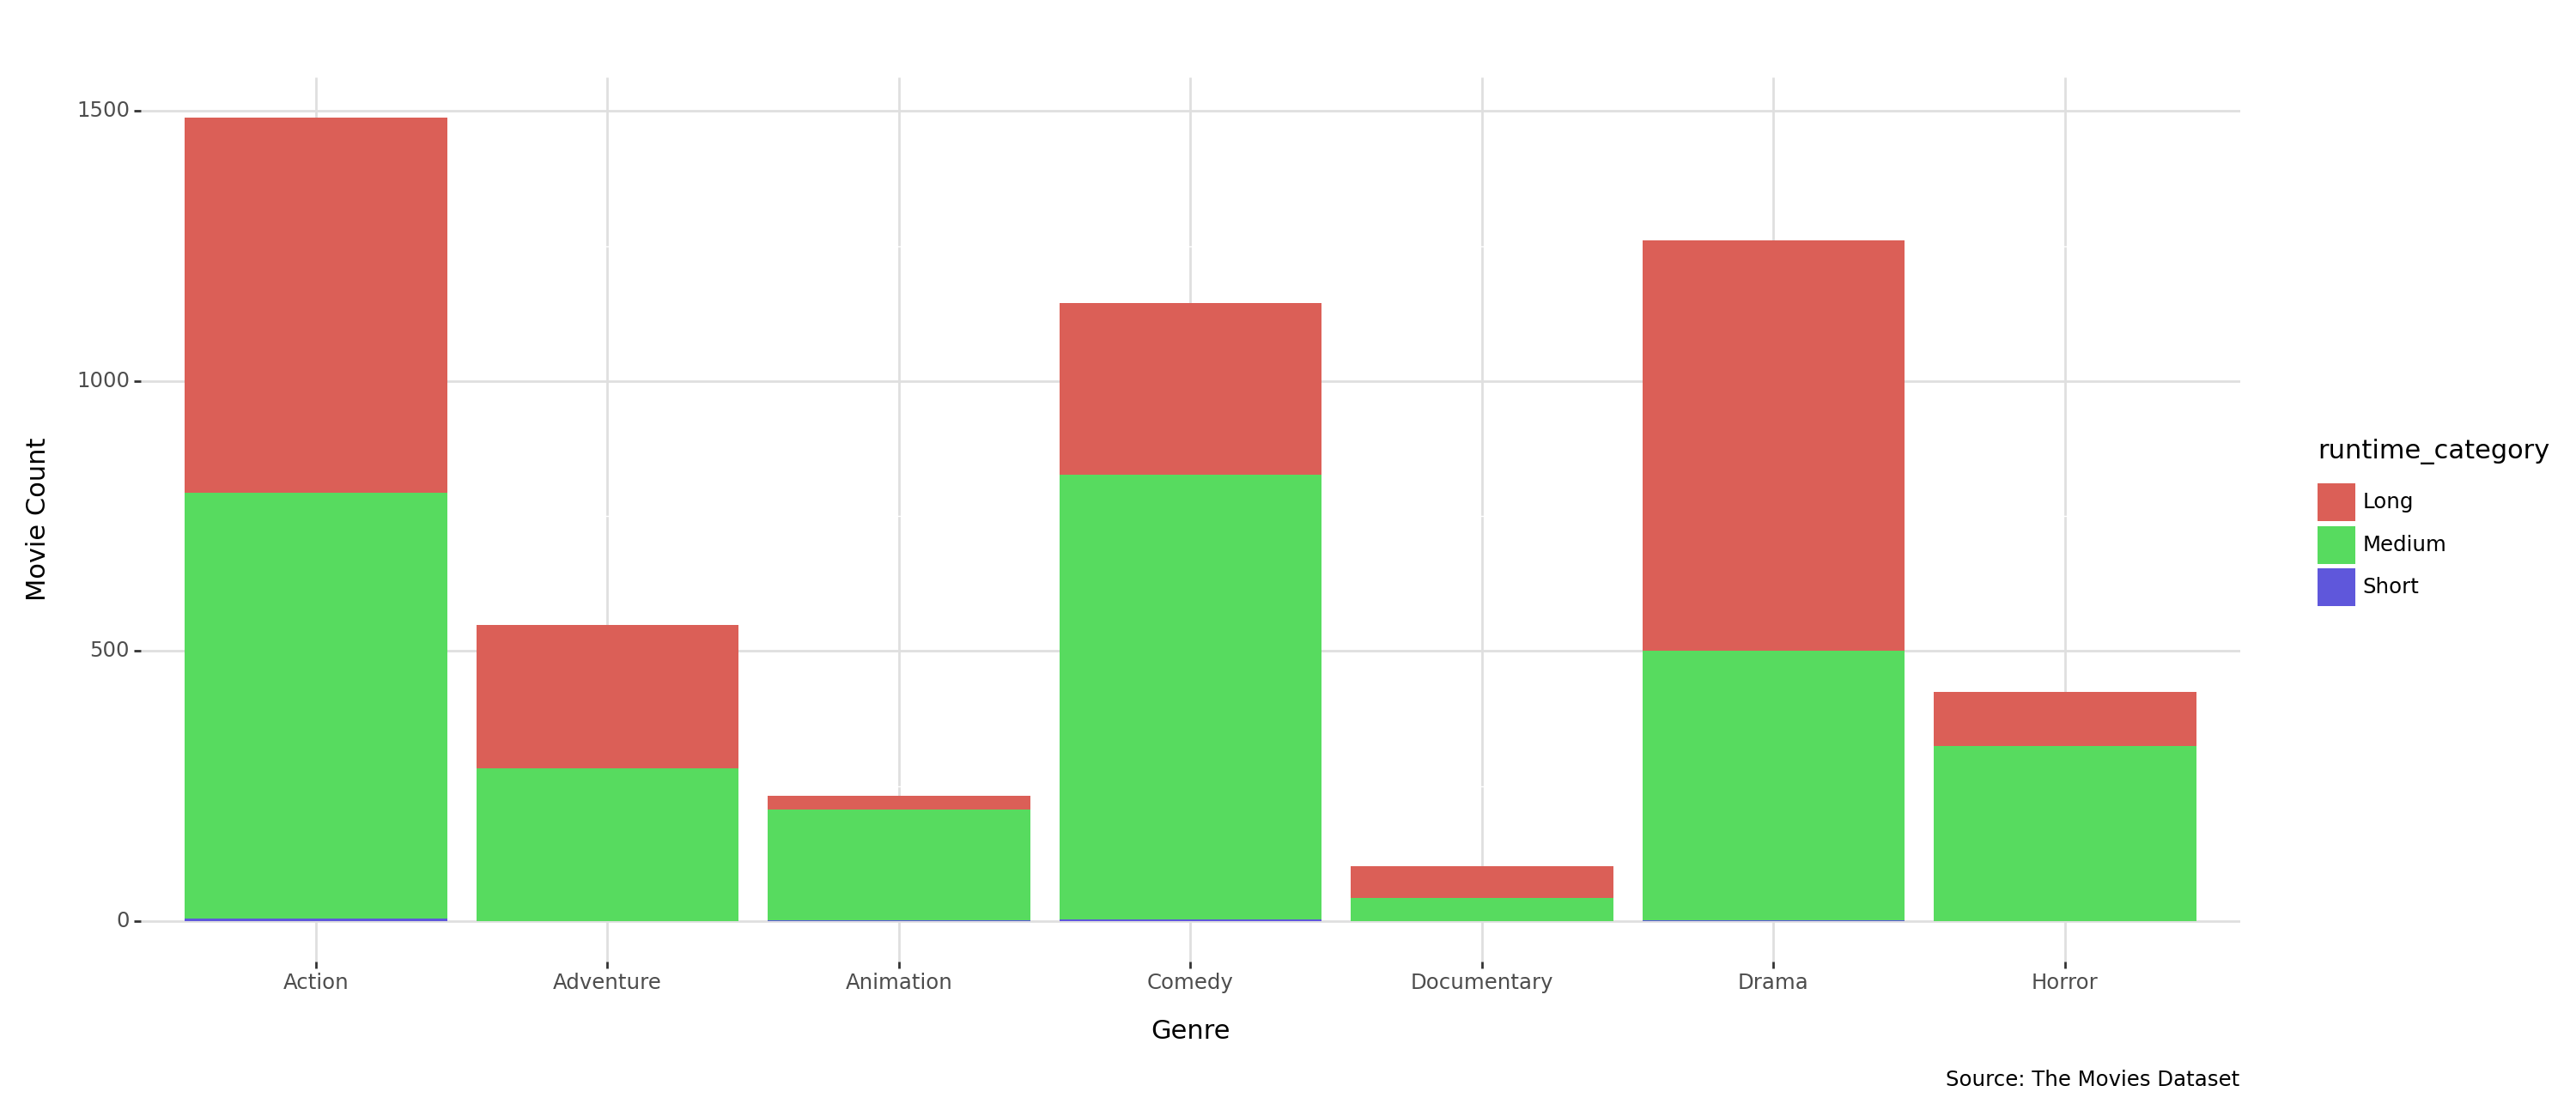

In [18]:
# Visualize the runtime categories by genre
df_runtime = df_md.groupby(["main_genre", "runtime_category"]).size().reset_index(name="count")
df_runtime = df_runtime.sort_values(by="count", ascending=False)

p = (
    p9.ggplot(df_runtime, p9.aes("main_genre", "count", fill="runtime_category"))
    + p9.geom_bar(stat="identity")
    + p9.labs(
        x="Genre",
        y="Movie Count",
    )
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        plot_caption=p9.element_text(text="Source: The Movies Dataset"),
    )
)

p.draw()


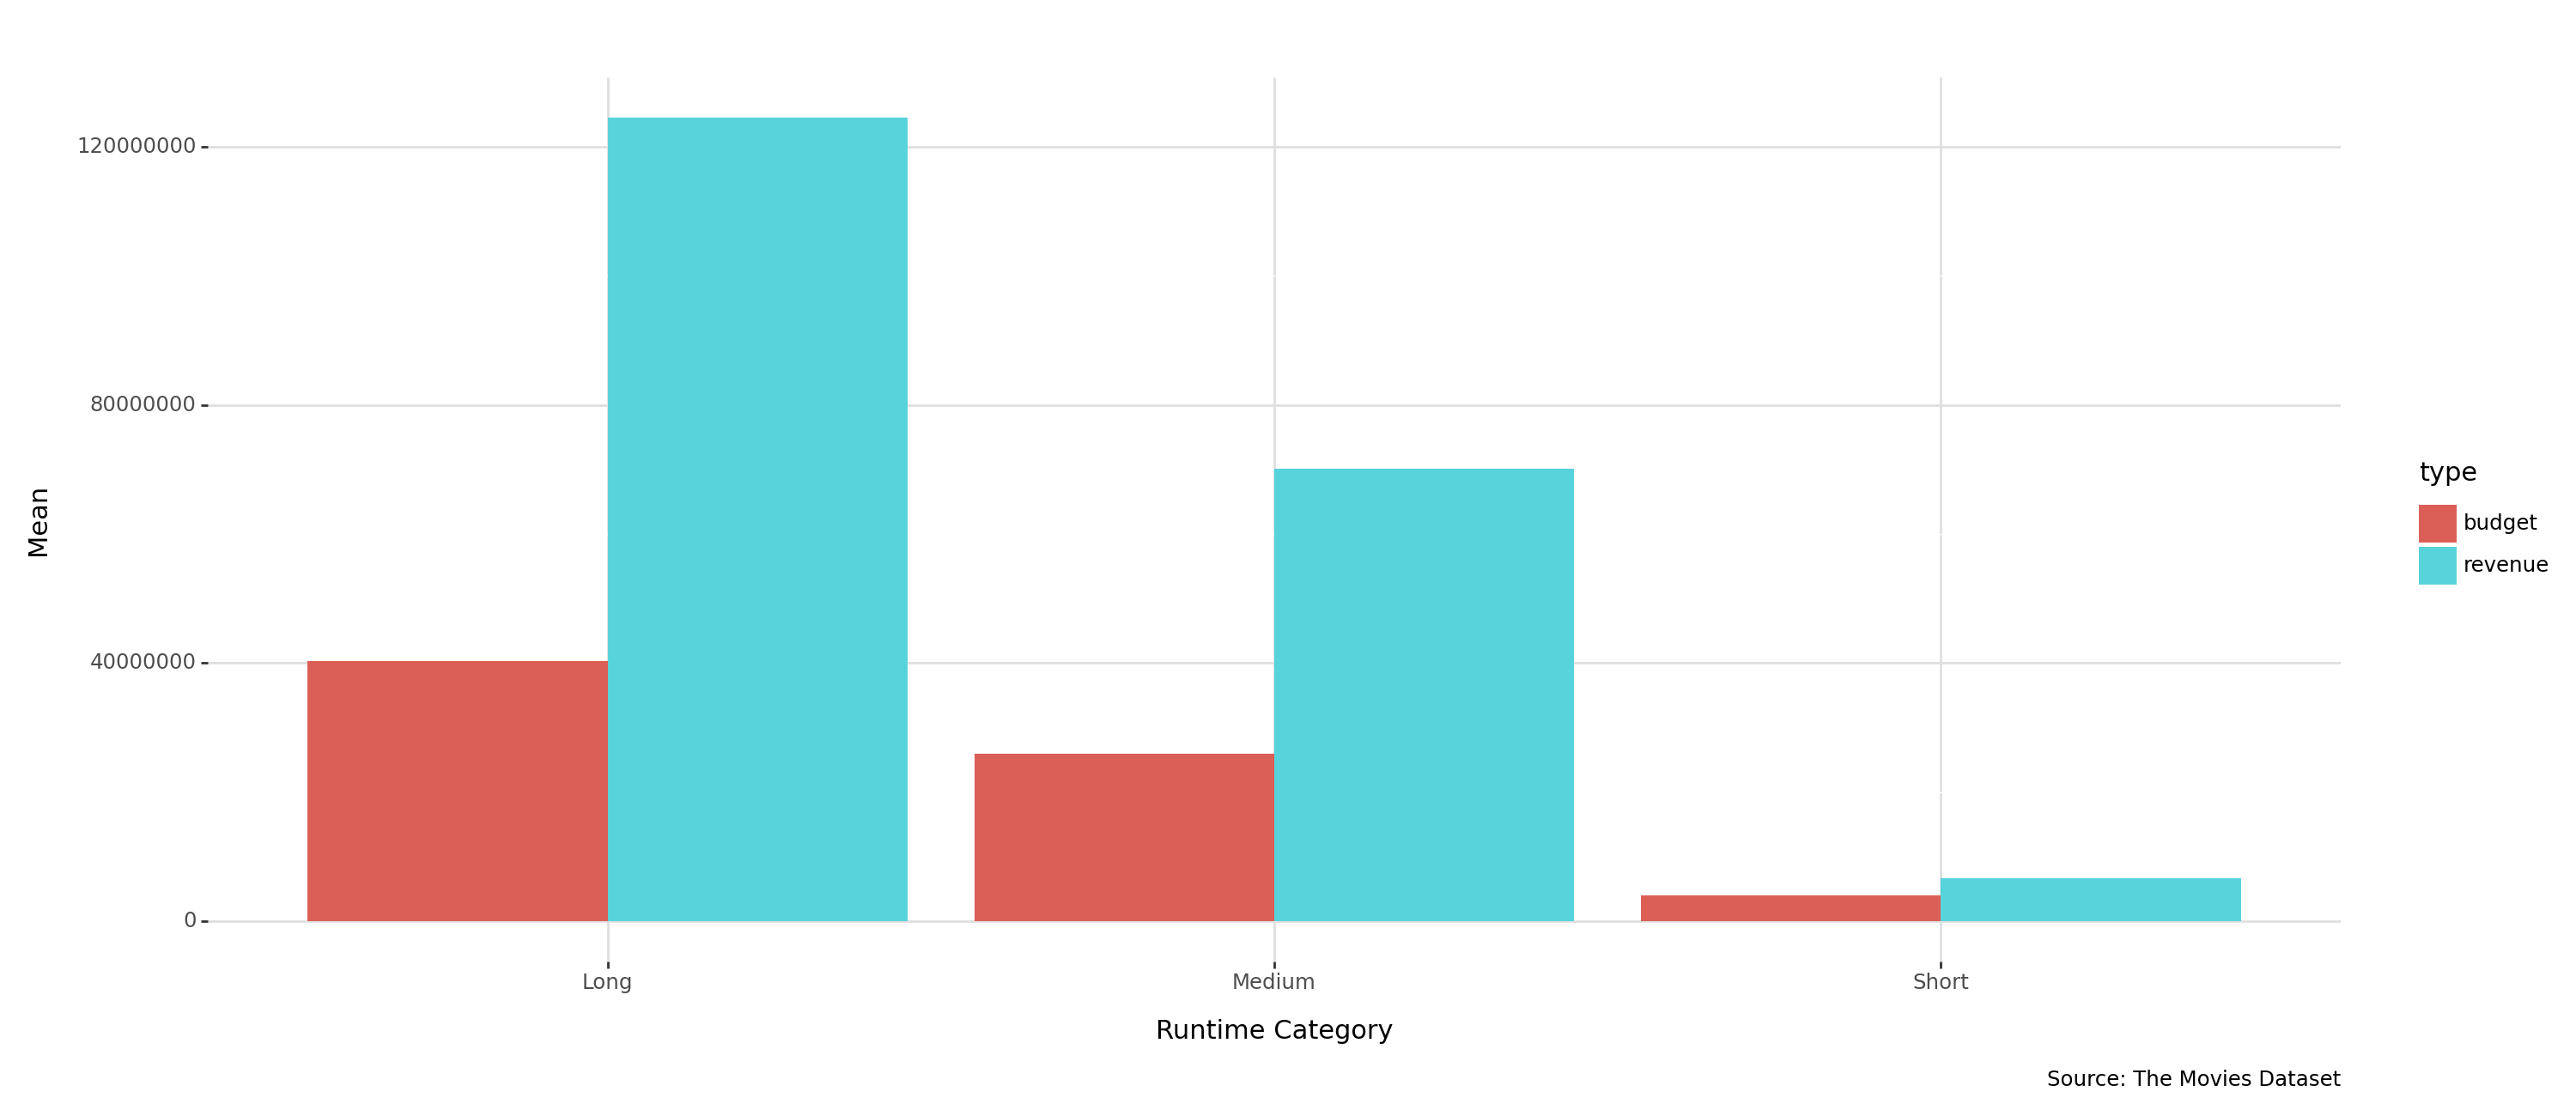

In [19]:
# Plot the runtime category, compared the budget and revenue
df_runtime = df_md.groupby(["runtime_category"]).agg(
    {"budget": "mean", "revenue": "mean"}
).reset_index()

df_runtime = pd.melt(
    df_runtime,
    id_vars=["runtime_category"],
    value_vars=["budget", "revenue"],
    var_name="type",
    value_name="value",
)

p = (
    p9.ggplot(df_runtime, p9.aes("runtime_category", "value", fill="type"))
    + p9.geom_bar(stat="identity", position="dodge")
    + p9.labs(
        x="Runtime Category",
        y="Mean",
    )
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        plot_caption=p9.element_text(text="Source: The Movies Dataset"),
    )
)

p.draw()


Average number of long movies per year: 62.42307692307692


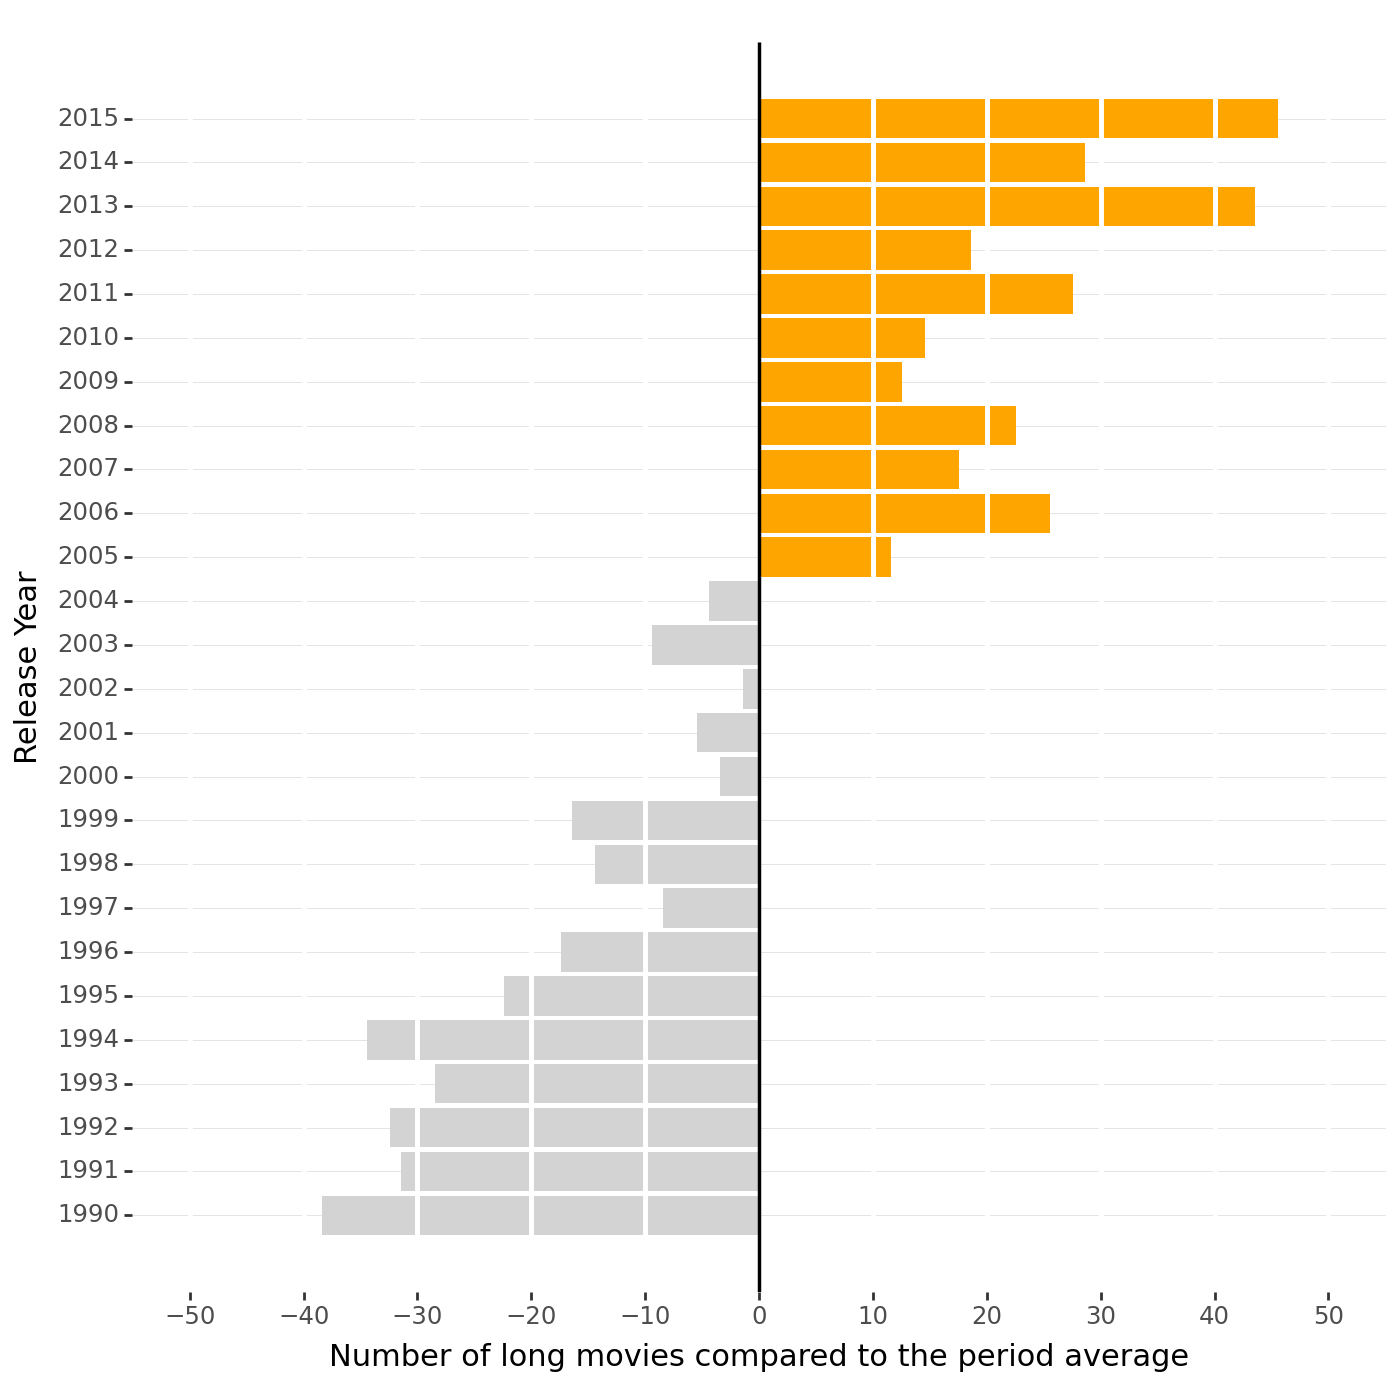

In [96]:
# We take the average number of long movies per year.
# We then plot the difference from the average per year on a bar chart.

df_long_movies = df_md[df_md["runtime_category"] == "Long"]
df_long_movies = df_long_movies.groupby("release_year").size().reset_index(name="count")
df_long_movies = df_long_movies.sort_values(by="release_year", ascending=True)
df_long_movies["count"] = df_long_movies["count"].astype(int)
df_long_movies = df_long_movies[df_long_movies["release_year"] >= 1990]
df_long_movies = df_long_movies[df_long_movies["release_year"] <= 2015]

average_long_movies_count = df_long_movies["count"].mean()

print(f"Average number of long movies per year: {average_long_movies_count}")

df_long_movies["count"] = df_long_movies["count"].apply(
    lambda x: x - average_long_movies_count
)

# Annotate the count with "Above average" and "Below average"
df_long_movies["above_average"] = df_long_movies["count"].apply(lambda x: x > 0)
df_long_movies["above_average"] = df_long_movies["above_average"].apply(
    lambda x: "Above average" if x else "Below average"
)

p = (
    p9.ggplot(df_long_movies, p9.aes("release_year", "count", fill="above_average"))
    + p9.geom_bar(stat="identity")
    + p9.labs(
        x="Release Year",
        y="Number of long movies compared to the period average",
    )
    + p9.coord_flip()
    + p9.scale_fill_manual(values={
        "Above average": "orange",
        "Below average": "lightgrey"
    })
    + p9.scale_x_continuous(breaks=range(1990, 2016, 1))
    + p9.scale_y_continuous(breaks=range(-50, 60, 10), expand=(0.05, 0.05))
    + p9.geom_hline(yintercept=range(-50, 0, 10), color="#ffffff", size=1)
    + p9.geom_hline(yintercept=range(10, 60, 10), color="#ffffff", size=1)
    + p9.geom_hline(yintercept=0, color="black", size=0.7)
    + p9.theme(
        figure_size=(7, 7),
        legend_position="none",
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=0.3),
    )
)
p.draw()


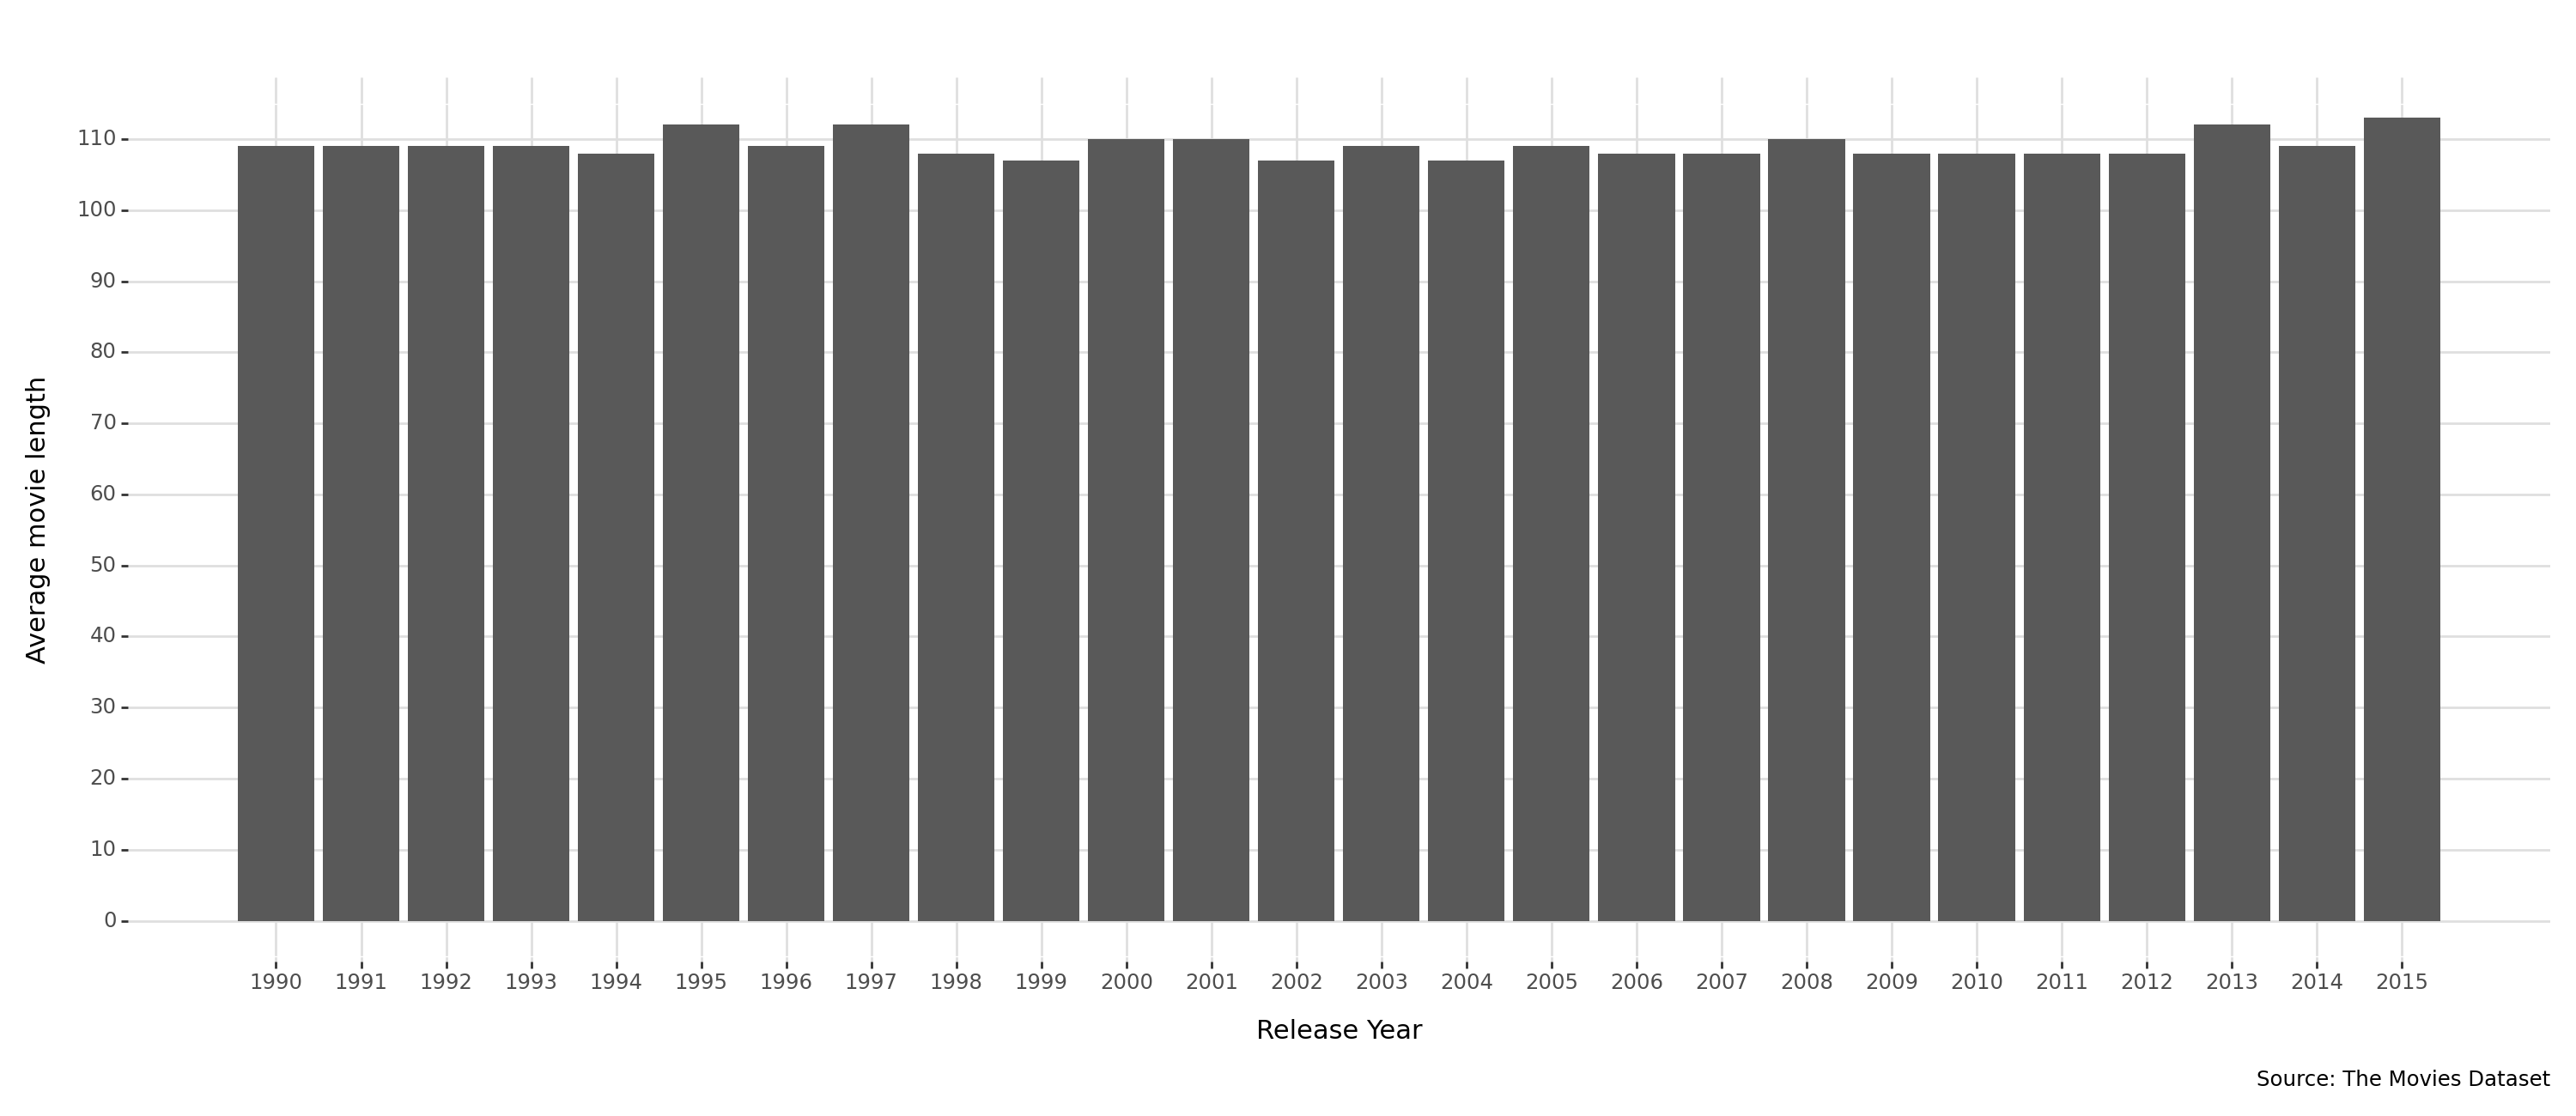

In [95]:
# Plot the average movie length by year from 1990 to 2015
df_runtime = df_md.groupby("release_year").agg({"runtime": "mean"}).reset_index()
df_runtime = df_runtime.sort_values(by="release_year", ascending=True)
df_runtime["runtime"] = df_runtime["runtime"].astype(int)
df_runtime = df_runtime[df_runtime["release_year"] >= 1990]
df_runtime = df_runtime[df_runtime["release_year"] <= 2015]

p = (
    p9.ggplot(df_runtime, p9.aes("release_year", "runtime"))
    + p9.geom_bar(stat="identity")
    + p9.labs(
        x="Release Year",
        y="Average movie length",
    )
    + p9.scale_x_continuous(breaks=range(1990, 2016, 1))
    + p9.scale_y_continuous(breaks=range(0, 200, 10), expand=(0.05, 0.05))
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        plot_caption=p9.element_text(text="Source: The Movies Dataset"),
    )
)

p.draw()
